In [21]:
import os
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2

import keras

print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.2.4


In [22]:
def img_to_1d_greyscale(img_path, size):
    # function for loading, resizing and converting an image into greyscale
    # used for logistic regression
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    return(pd.Series(img.flatten()))

In [23]:
citizen_files = os.listdir('train/citizens')
mafia_files = os.listdir('train/mafia')
text_files = os.listdir('test')

SIZE = (256, 256)
DIVISOR = 256  # TODO What is this?
SOLVER = 'liblinear'

files = []
for directory, filetype in (
    ('train/citizens', 'citizen'),
    ('train/mafia', 'mafia'),
    ('test', 'test'),
):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            Image.open(filepath)
        except OSError:
            continue
        files.append({
            'path': filepath,
            'type': filetype,
        })


training_files = [f for f in files if f['type'] in ('citizen', 'mafia')]
training_size = len(training_files)
# Initialize training data
X_train = pd.DataFrame(np.zeros((training_size, SIZE[0] * SIZE[1])))
y_train = [None] * training_size
for i, f in enumerate(tqdm(training_files)):
    X_train.iloc[i, :] = img_to_1d_greyscale(f['path'], SIZE) / DIVISOR
    y_train[i] = f['type']
# Initialize test data
test_files = [f for f in files if f['type'] in ('test',)]
test_size = len(test_files)
X_test = pd.DataFrame(np.zeros((test_size, SIZE[0] * SIZE[1])))
y_test = [None] * test_size
for i, f in enumerate(tqdm(test_files)):
    X_test.iloc[i, :] = img_to_1d_greyscale(f['path'], SIZE) / DIVISOR


100%|██████████| 18/18 [00:00<00:00, 24.62it/s]


In [24]:
plt.imshow(np.reshape(X_train.iloc[0, ].values, SIZE))

Test Accuracy
=====

In [25]:
# For each photo in the training set, remove it from the training set and use it as a test.
citizen_accuracy = []
mafia_accuracy = []

def test():
    for i in tqdm(range(len(X_train))):
        Xi_test = [X_train.iloc[i,]]
        yi_test = [y_train[i]]
        Xi_train = X_train.iloc[[n for n in range(len(X_train)) if n != i]]
        yi_train = y_train[:i] + y_train[i + 1:]
        i_classifier = LogisticRegression(solver=SOLVER)
        i_classifier.fit(Xi_train, yi_train)
        prob = i_classifier.predict_proba(Xi_test)[0]
        prob = dict(zip(i_classifier.classes_, prob))
#         print(yi_test[0], prob[yi_test[0]])
        if yi_test[0] == 'citizen':
            citizen_accuracy.append(prob[yi_test[0]])
        else:
            mafia_accuracy.append(prob[yi_test[0]])
test()

100%|██████████| 82/82 [01:57<00:00,  1.44s/it]


0.779092629741167 0.05109992410898767


([array([42.,  3.,  2.,  1.,  4.,  2.,  1.,  5.,  2.,  4.]),
  array([13.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])],
 array([3.29761227e-06, 9.98523354e-02, 1.99701373e-01, 2.99550411e-01,
        3.99399449e-01, 4.99248487e-01, 5.99097524e-01, 6.98946562e-01,
        7.98795600e-01, 8.98644638e-01, 9.98493676e-01]),
 <a list of 2 Lists of Patches objects>)

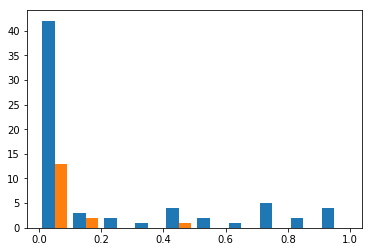

In [26]:
print(sum(citizen_accuracy)/len(citizen_accuracy),sum(mafia_accuracy)/len(mafia_accuracy))
plt.hist([[1-i for i in citizen_accuracy], mafia_accuracy])

Classify Unknown Images
=======

In [27]:
logreg_classifier = LogisticRegression(solver=SOLVER)

In [28]:
logreg_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
for f, pred in zip(test_files, logreg_classifier.predict_proba(X_test)):
#     f['citizen %'] = pred[0] * 100
#     f['mafia %'] = pred[1] * 100
    f['prediction'] = pred

In [30]:
for f in sorted(test_files, key=lambda f: f['prediction'][0]):
    print("{}: {:.3}%".format(f['path'][5:], f['prediction'][1] * 100))

g3w1-juilan.jpg: 61.1%
g3w1-andy-e.jpg: 30.1%
g3w1-jesse.jpg: 17.7%
g3w1-andy-m.jpg: 14.2%
g3w1-dave.jpg: 10.3%
g3w2-dave.png: 6.43%
g3w2-andy-m.png: 3.25%
g3w2-max.jpg: 3.24%
g3w1-jamie.jpg: 2.52%
g3w2-vib.jpg: 2.1%
g3w2-jesse.png: 0.879%
g3w2-julian.jpg: 0.73%
g3w2-andy-e.jpg: 0.287%
g3w2-pennie.jpg: 0.0938%
g3w1-max.jpg: 0.00379%
g3w1-vib.jpg: 0.00291%
g3w1-pennie.jpg: 0.00273%
g3w2-jamie.png: 0.000463%
